# Extract intensity and spatial features from ICLs

extract features with
`scripts/extract_features.sh`

TODO mean intensity plot remove cluster all + change zscoring? 


In [1]:
from miann.tl import Experiment, FeatureExtractor
import os
from miann.pl import plot_mean_intensity, zscore, get_intensity_change, plot_intensity_change, plot_mean_size, plot_size_change
import anndata as ad
from miann.utils import init_logging
init_logging()

## Explore features for VAE_SBF2/CondVAE_siRNA-CC

In [2]:
exp = Experiment.from_dir('VAE_SBF2/CondVAE_siRNA-CC')

INFO:Experiment:Setting up experiment VAE_SBF2/CondVAE_siRNA-CC
INFO:Experiment:Initialised from existing experiment in VAE_SBF2/CondVAE_siRNA-CC


### clustering_res0.9_sub-0.33_seed1

In [27]:
# load extracted features for clustering_res0.9_sub-0.33_seed1
extrs = [FeatureExtractor.from_adata(os.path.join(exp.full_path, 'aggregated/full_data', data_dir, 'features_seed1.h5ad')) for data_dir in exp.data_params['data_dirs']]

# get combined adata for dotplots
adatas = [extr.get_intensity_adata() for extr in extrs]
adata = ad.concat(adatas, index_unique='-')
zscore(adata, limit_to_groups={'siRNA':'scrambled'})

INFO:Experiment:Setting up experiment VAE_SBF2/CondVAE_siRNA-CC
INFO:Experiment:Initialised from existing experiment in VAE_SBF2/CondVAE_siRNA-CC
INFO:Experiment:Setting up experiment VAE_SBF2/CondVAE_siRNA-CC
INFO:Experiment:Initialised from existing experiment in VAE_SBF2/CondVAE_siRNA-CC
INFO:Experiment:Setting up experiment VAE_SBF2/CondVAE_siRNA-CC
INFO:Experiment:Initialised from existing experiment in VAE_SBF2/CondVAE_siRNA-CC
INFO:Experiment:Setting up experiment VAE_SBF2/CondVAE_siRNA-CC
INFO:Experiment:Initialised from existing experiment in VAE_SBF2/CondVAE_siRNA-CC
INFO:Experiment:Setting up experiment VAE_SBF2/CondVAE_siRNA-CC
INFO:Experiment:Initialised from existing experiment in VAE_SBF2/CondVAE_siRNA-CC
INFO:Experiment:Setting up experiment VAE_SBF2/CondVAE_siRNA-CC
INFO:Experiment:Initialised from existing experiment in VAE_SBF2/CondVAE_siRNA-CC


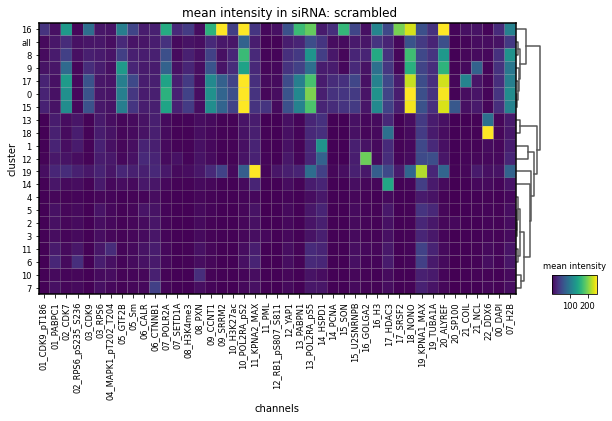

In [30]:
plot_mean_intensity(adata, groupby='cluster', limit_to_groups={'siRNA':'scrambled'}, dendrogram=True, layer=None, vmax=250)

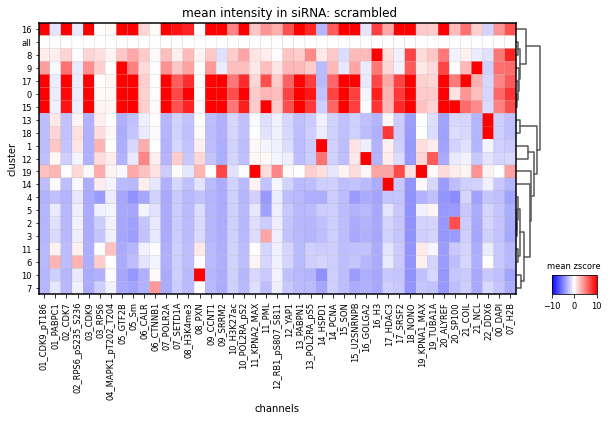

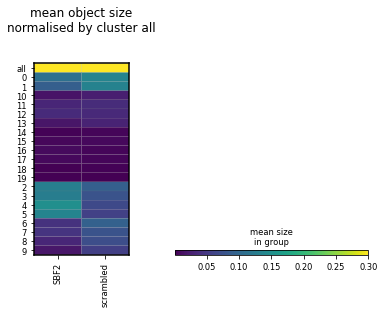

In [4]:
plot_mean_intensity(adata, groupby='cluster', limit_to_groups={'siRNA':'scrambled'}, dendrogram=True, layer='zscored', cmap='bwr', vmin=-10, vmax=10)
plot_mean_size(adata, groupby_row='cluster', groupby_col='siRNA', normby_row='all', vmax=0.3)

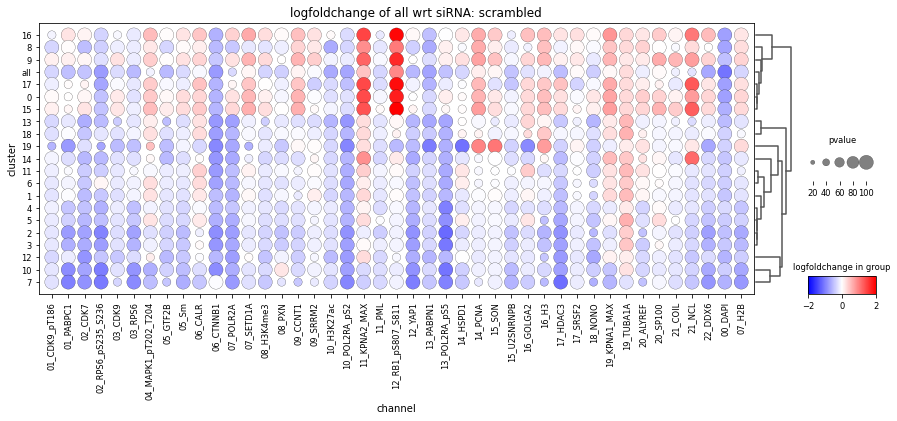

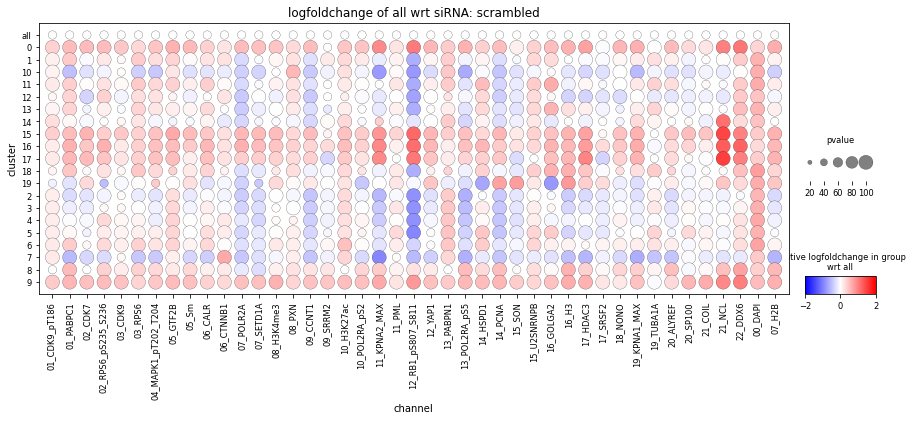

In [5]:
res = get_intensity_change(adata, groupby='cluster', reference_group='siRNA', reference='scrambled', color='logfoldchange', size='pval')
plot_intensity_change(**res, adjust_height=True, figsize=(15,5), vmin=-2, vmax=2, dendrogram=True)

res = get_intensity_change(adata, groupby='cluster', reference_group='siRNA', reference='scrambled', color='logfoldchange', size='pval', norm_by_group='all')
plot_intensity_change(**res, adjust_height=True, figsize=(15,5), vmin=-2, vmax=2)

### clustering_res0.9_sub-0.33_seed1 annotation

In [6]:
# load extracted features for clustering_res0.9_sub-0.33_seed1
extrs = [FeatureExtractor.from_adata(os.path.join(exp.full_path, 'aggregated/full_data', data_dir, 'features_seed1_annotation.h5ad')) for data_dir in exp.data_params['data_dirs']]

# get combined adata for dotplots
adatas = [extr.get_intensity_adata() for extr in extrs]
adata = ad.concat(adatas, index_unique='-')
zscore(adata, limit_to_groups={'siRNA':'scrambled'})

INFO:Experiment:Setting up experiment VAE_SBF2/CondVAE_siRNA-CC
INFO:Experiment:Initialised from existing experiment in VAE_SBF2/CondVAE_siRNA-CC
INFO:Experiment:Setting up experiment VAE_SBF2/CondVAE_siRNA-CC
INFO:Experiment:Initialised from existing experiment in VAE_SBF2/CondVAE_siRNA-CC
INFO:Experiment:Setting up experiment VAE_SBF2/CondVAE_siRNA-CC
INFO:Experiment:Initialised from existing experiment in VAE_SBF2/CondVAE_siRNA-CC
INFO:Experiment:Setting up experiment VAE_SBF2/CondVAE_siRNA-CC
INFO:Experiment:Initialised from existing experiment in VAE_SBF2/CondVAE_siRNA-CC
INFO:Experiment:Setting up experiment VAE_SBF2/CondVAE_siRNA-CC
INFO:Experiment:Initialised from existing experiment in VAE_SBF2/CondVAE_siRNA-CC
INFO:Experiment:Setting up experiment VAE_SBF2/CondVAE_siRNA-CC
INFO:Experiment:Initialised from existing experiment in VAE_SBF2/CondVAE_siRNA-CC


In [19]:
plot_mean_intensity(adata, groupby='cluster', limit_to_groups={'siRNA':'scrambled'}, dendrogram=True, layer='zscored', cmap='bwr', vmin=-10, vmax=10)
plot_mean_size(adata, groupby_row='cluster', groupby_col='siRNA', normby_row='all', vmax=0.3)

In [24]:
res = get_intensity_change(adata, groupby='cluster', reference_group='siRNA', reference='scrambled', color='logfoldchange', size='pval')
plot_intensity_change(**res, adjust_height=True, figsize=(15,5), vmin=-2, vmax=2, dendrogram=True)

res = get_intensity_change(adata, groupby='cluster', reference_group='siRNA', reference='scrambled', color='logfoldchange', size='pval', norm_by_group='all')
plot_intensity_change(**res, adjust_height=True, figsize=(15,5), vmin=-2, vmax=2)

{'data_dir': '184A1_SBF2/K18',
 'cluster_name': 'clustering_res0.9_sub-0.33_seed1',
 'cluster_dir': 'aggregated/sub-0.005_sub-0.33',
 'cluster_col': 'annotation',
 'exp_name': 'VAE_SBF2/CondVAE_siRNA-CC'}